In [1]:
#importing libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#loading dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


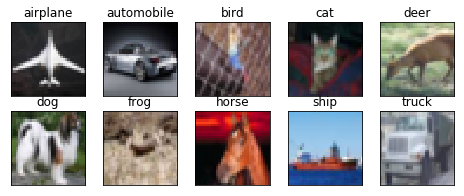

In [3]:
#class names and dummy random images
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#plot function
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#accuracy function
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#train and test features 
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Normal Convolution
Separable Convolution 
Depthwise Convolution
Grouped Convolution (use 3x3, 5x5 only)
Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

In [8]:
# Define the model

from keras.layers import Input,SeparableConv2D,DepthwiseConv2D
from keras.layers.merge import concatenate
import keras

input_shape = Input(shape=(32,32,3))

#normal conv
layer1=Convolution2D(16, 3, 3, border_mode='same')(input_shape)    ## 32x32  ## 3
layer1 = BatchNormalization()(layer1)
layer1= Activation('relu')(layer1)
layer1= Dropout(0.20)(layer1)

#seprable convolutions  3x1
layer2 = Convolution2D(32,(3,1),border_mode='same')(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = Activation('relu')(layer2)
layer2 = Dropout(0.20)(layer2)

#seprable convolutions  1x3
layer3 = Convolution2D(32,(1,3),border_mode='same')(layer2)
layer3 = BatchNormalization()(layer3)
layer3 = Activation('relu')(layer3)
layer3 = Dropout(0.20)(layer3)

#transition layer
trans_1 = Convolution2D(16,(1,1),border_mode='same')(layer3)
max_1=MaxPooling2D(pool_size=(2, 2))(trans_1)

#depthwise conv
layer4 = SeparableConv2D(32,(3,3),padding='same')(max_1)
layer4 = BatchNormalization()(layer4)
layer4 = Activation('relu')(layer4)
layer4 = Dropout(0.20)(layer4)


#grouped kernels ::

#convolution layer of 3x3
layer5 = Convolution2D(64,(3,3),border_mode='same')(layer4)
layer5 = BatchNormalization()(layer5)
layer5 = Activation('relu')(layer5)
layer5 = Dropout(0.20)(layer5)

#convolution layer of 5x5
layer6 = Convolution2D(64,(5,5),border_mode='same')(layer5)
layer6 = BatchNormalization()(layer6)
layer6 = Activation('relu')(layer6)
layer6 = Dropout(0.20)(layer6)

#concatenation of 2 grouped convolutions
con_grp = concatenate([layer5,layer6])


###transition layer
trans_2 = Convolution2D(32,(1,1),border_mode='same')(con_grp)
max_2=MaxPooling2D(pool_size=(2, 2))(trans_2)

##grouped convolutions with dilation

#3x3 with dilation rate ==1 
layer7 = Convolution2D(64,(3,3),dilation_rate=1,border_mode='same')(max_2)
layer7 = BatchNormalization()(layer7)
layer7 = Activation('relu')(layer7)
layer7 = Dropout(0.20)(layer7)

#3x3 with dilation rate ==2
layer8 = Convolution2D(64,(3,3),border_mode='same',dilation_rate=2)(layer7)
layer8 = BatchNormalization()(layer8)
layer8 = Activation('relu')(layer8)
layer8 = Dropout(0.20)(layer8)

#concatenation of 2 grouped convolutions
con_grpd = concatenate([layer7,layer8])

#1x1 layer to reduce parameters
trans_3 = Convolution2D(16,(1,1),border_mode='same')(con_grpd)

last_conv = Convolution2D(10,8)(trans_3)


flat=Flatten()(last_conv)
act = Activation('softmax')(flat)
# Compile the model
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Conv2D` call to the Keras 2 API: `C

In [9]:
#model compilation
model = keras.models.Model(inputs=[input_shape], outputs=act)
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 32, 32, 16)   0           batch_normalization_4[0][0]      
__________________________________________________________________________________________________
dropout_4 

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 19s 49ms/step - loss: 1.6923 - acc: 0.3875 - val_loss: 2.8371 - val_acc: 0.2599
Epoch 2/50
390/390 [==============================] - 14s 36ms/step - loss: 1.3170 - acc: 0.5194 - val_loss: 2.3961 - val_acc: 0.3039
Epoch 3/50
390/390 [==============================] - 14s 36ms/step - loss: 1.1465 - acc: 0.5877 - val_loss: 1.9394 - val_acc: 0.4066
Epoch 4/50
390/390 [==============================] - 14s 36ms/step - loss: 1.0215 - acc: 0.6368 - val_loss: 1.4085 - val_acc: 0.5413
Epoch 5/50
390/390 [==============================] - 14s 36ms/step - loss: 0.9290 - acc: 0.6703 - val_loss: 1.0778 - val_acc: 0.6287
Epoch 6/50
390/390 [==============================] - 14s 36ms/step - loss: 0.8545 - acc: 0.6962 - val_loss: 1.0552 - val_acc: 0.6446
Epoch 7/50
390/390 [==============================] - 14s 36ms/step - loss: 0.7978 - acc: 0.7164 - val_loss: 1.5012 - val_acc: 0.5485
Epoch 8/50
390/390 [==============================] - 14s 36ms

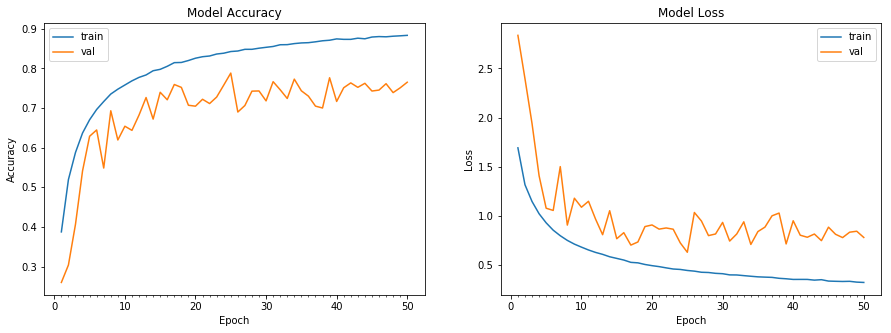

Accuracy on test data is: 76.50


In [10]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

#getting around 89% accuracy in 50 epochs.